# FYS5555 Statistics Notebook

Welcome to the FYS5555 statistics notebook! Here you will find some examples of how to use the "pyStats" code to define counting experiments with one or multiple channels and calculate exclusion limits and significances.

## Getting started

To get started, we just import the "pyStats" module. We also import "TMath" from ROOT, which we will use to do some analytical cross checks.

In [1]:
import pyStats;
from ROOT import TMath;


Welcome to the ATLAS rootlogon.C
Welcome to JupyROOT 6.24/02


Info in <TUnixSystem::ACLiC>: creating shared library /storage/galaxy/jobs_directory/003/3185/working/jupyter/Notebooks/Statistics/./MC_Bayes_withBkgCorr_cpp.so


## A first example

We create a first example counting experiment. Let's assume that we have a perfectly known background of 100 events, and we are interested in the significance of a potential signal of 20 events, leading to 120 observed events. We create a counting experiment object and add the relevant channel with corresponding background level, uncertainty, and number of observed events. We then print the object to see that all information has been entered correctly.

In [2]:
countexp = pyStats.countingExperiment();
countexp.addChannel('My channel', bkg = 100.0, bkgUnc = 0.0, Nobs = 120);
print(countexp);

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 100.0 +/- 0.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0



You can notice that we here did not specify an integrated luminosity, so this is set to 1 by default, and a default value of 1 is also set for the signal efficiency. In practice, this means that limit results will be expressed in terms of the number of signal events. However, let's focus first on the significance. We get the significance of this 20-events excess from the function getSignificance(), which employs the asymptotic approximation based on the profile likelihood ratio. We can also cross check the result using some well-known analytical expressions. The first one is the usual $s/\sqrt{b}$ that assumes a Gaussian approximation for the Poisson distribution. The second one is the analytical result based on the profile likelihood ratio (see [here](https://www.pp.rhul.ac.uk/~cowan/stat/notes/SigCalcNote.pdf), Equation (27)).

In [3]:
print( "Significance = ", countexp.getSignificance() );
print( "Significance ( s/sqrt(b) ) = ", 20./TMath.Sqrt(100.) );
print( "Significance ( sqrt(2((s+b)ln(1+s/b)-s)) ) = ", TMath.Sqrt( 2.*(120.*TMath.Log(1.+20./100.) - 20. ) ) );

Significance =  1.9383430115285685
Significance ( s/sqrt(b) ) =  2.0
Significance ( sqrt(2((s+b)ln(1+s/b)-s)) ) =  1.9383430115820843


As expected, the simple $s/\sqrt{b}$ comes close to the profile likelihood ratio result, because with 100 expected background events, the Poisson distribution is approximately Gaussian. The analytical expression based on the profile likelihood ratio gives a practically identical result to the numerical calculation, as expected. As a final check, we also calculate the exact Poisson p-value, i.e. the probability to observe at least 120 events when 100 events are expected:

In [4]:
pValue = 0.0;

for n in range(120,200): #the upper limit is in principle infinite, but we need a cut-off for the calculation
    pValue += TMath.Poisson(n,100.);

print( "p-value = ", pValue );
print( "Significance = ", TMath.Abs(TMath.NormQuantile(pValue)) ); #convert p-value to significance

p-value =  0.028230393964867945
Significance =  1.9074619952992748


Let's see what happens if we add a systematic uncertainty on the background estimate. We add an uncertainty of 10 events. This uncertainty needs to be modeled by a certain distribution, referred to in Bayesian terminology as a "prior" and in Frequentist settings usually as a "constraint". We here choose a Gaussian distribution to model the uncertainty, while the default in the code would be a log-normal distribution.

In [5]:
countexp = pyStats.countingExperiment();
countexp.addChannel('My channel', bkg = 100.0, bkgUnc = 10.0, Nobs = 120);
countexp.setPriors(bkg='gauss');
print(countexp);

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 100.0 +/- 10.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0



We can now calculate the corresponding significance. As before, we try to understand the result using an analytical calculation. In this case, we can think of the "statistical uncertainty" $\sqrt{b}$ and the systematic uncertainty $\sigma_b$ as uncorrelated sources, which then add in quadrature to form an effective "total uncertainty" on the background. (Note the use of quote marks here, as the statistical component is not really an uncertainty on the background level $b$, but just something that quantifies the expected statistical fluctuations of the observed result around its expectation value.)

In [6]:
print( "Significance = ", countexp.getSignificance() );
print( "Significance ( s/sqrt(b + sigma_b^2) ) = ", 20./TMath.Sqrt(100. + 10.**2) );

Significance =  1.370615487755145
Significance ( s/sqrt(b + sigma_b^2) ) =  1.414213562373095


Here we see that the simple analytical expression comes very close to the full profile likelihood ratio treatment.

## Combining channels

Often a searched-for particle has multiple decay modes that can be individually reconstructed in the experiment. The optimal sensitivity is achieved by the proper statistical combination of all channels, achieved by constructing the likelihood as a product of the individual-channel Poisson likelihoods.

Let's return to our previous result without systematic uncertainty on the background level:

In [7]:
countexp = pyStats.countingExperiment();
countexp.addChannel('My channel', bkg = 100.0, bkgUnc = 0.0, Nobs = 120);
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 100.0 +/- 0.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0

Significance =  1.9383430115285685


If our signal prediction is 20 events in this channel, we can think of this result as an expected significance (calculated from the so-called "Asimov dataset" under the signal+background hypothesis). What if we had another, statistically independent, channel with the same background and signal expectations? The situation would look like this:

In [8]:
countexp = pyStats.countingExperiment('A combination');
countexp.addChannel('First channel', bkg = 100.0, bkgUnc = 0.0, Nobs = 120);
countexp.addChannel('Second channel', bkg = 100.0, bkgUnc = 0.0, Nobs = 120);
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "A combination"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "First channel":
   Background = 100.0 +/- 0.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0
Channel "Second channel":
   Background = 100.0 +/- 0.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0

Significance =  2.741230975509669


Aha! So by adding the information provided by the second channel, we increased our expected significance from 1.9 sigma to 2.7 sigma. In this case, since the signal-to-background ratio is identical in the two channels, we could achieve the same thing by simply adding together the numbers characterizing the two channels:

In [9]:
countexp = pyStats.countingExperiment();
countexp.addChannel('Inclusive channel', bkg = 100.0+100.0, bkgUnc = 0.0, Nobs = 120+120);
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "Inclusive channel":
   Background = 200.0 +/- 0.0
   Observed events = 240
   Signal efficiency = 1.0 +/- 0.0

Significance =  2.7412309755104567


It is also worth noting that the increase in expected significance from adding the additional channel corresponds exactly to a factor $\sqrt{2}$, as expected from considering for example the simple formula $s/\sqrt{b}$.

The previous example considered the case of two identical channels, i.e. both with the same background and signal expectations. This might be approximately representative of combining for example results from a final state with electrons with the corresponding results involving muons instead of electrons, except for differences due to the lepton reconstruction and identification efficiency or momentum resolutions. We saw that in the case of identical channels, a "proper" combination involving a likelihood product gave identical results as the simple summation of the results in the two channels. Now, what if the properties of the channels are quite different? Consider a channel with a low background expectation and high signal-to-background ratio, for example with a background expectation of 1.25 events and a signal expectation of 2.75 events, leading to 4 expected events under the signal+background hypothesis:

In [10]:
countexp = pyStats.countingExperiment();
countexp.addChannel('My channel', bkg = 1.25, bkgUnc = 0.0, Nobs = 4);
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 1.25 +/- 0.0
   Observed events = 4
   Signal efficiency = 1.0 +/- 0.0

Significance =  1.9506938453847018


We see that this gives almost identical significance as our previous channel with 100 expected background events and 20 expected signal events. What if the observations in the two channels could be explained by the same hypothetical particle, what would be the combined significance of the observed excesses in the two channels? In this case, a simple summation of the two channels does not provide a very substantial increase in the significance compared to each individual channel by itself:

In [11]:
countexp = pyStats.countingExperiment();
countexp.addChannel('Inclusive channel', bkg = 100.0+1.25, bkgUnc = 0.0, Nobs = 120+4);
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "Inclusive channel":
   Background = 101.25 +/- 0.0
   Observed events = 124
   Signal efficiency = 1.0 +/- 0.0

Significance =  2.1833087698182743


So, before when we were combining two channels with 1.94 sigma significance, the resulting significance was 2.74 sigma, but now we get only 2.18 sigma? The reason for this is that the results of the "low-statistics" channel tend to "drown" a bit when added to the "high-statistics" channel. Thus, to optimally benefit from the available sensitivity in the two different channels, a proper likelihood product combination must be performed. However, now we must stop and think for a second. We assumed that our signal model predicts *at the same time* a signal contribution of 20 events in the "high-statistics" channel and 2.75 events in the "low-statistics" channel. In other words, our hypothetical particle has different branching fractions to these final states. (Or the reconstruction and identification efficiencies of the channels are very different.) Assuming that it's the branching fraction that explains the different signal prediction in the two channels, it's easy enough to calculate the branching fractions corresponding to the assumed signal predictions, which we encode in the statistical model via the signal efficiencies of the two channels:

In [12]:
countexp = pyStats.countingExperiment();
countexp.addChannel('High-statistics channel', bkg = 100.0, bkgUnc = 0.0, Nobs = 120, eff = 0.879);
countexp.addChannel('Low-statistics channel', bkg = 1.25, bkgUnc = 0.0, Nobs = 4, eff = 0.121);
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "High-statistics channel":
   Background = 100.0 +/- 0.0
   Observed events = 120
   Signal efficiency = 0.879 +/- 0.0
Channel "Low-statistics channel":
   Background = 1.25 +/- 0.0
   Observed events = 4
   Signal efficiency = 0.121 +/- 0.0

Significance =  2.7499779179498036


Aha! Using the proper likelihood combination of the two channels, the resulting significance is just as high as when we were combining the two high-statistics channels. So in the case of channels with very different signal-to-background ratios, a proper likelihood combination is really the only way to go. A good "real-life" example of combining channels with very different signal-to-background ratios is in the [search for the Higgs boson](https://arxiv.org/abs/1207.7214), where comparable sensitivities are provided by the diphoton and four-lepton channels. In the diphoton channel, the expected signal contribution is of the order of a few hundred events, which is small compared to the background of thousands of events, while in the four-lepton channel, only a handful of signal events is expected, with a correspondingly low background expectation.

A final thing is worth noting here before we move on: In order to obtain the optimal significance for the combination of the "high-statistics" and "low-statistics" channels, we had to insert into our statistical model a specific prediction for the relative signal contribution in the two channels, as encoded in the signal efficiencies (which in general correspond to some combination of experimental efficiencies and theoretical predictions such as branching fractions). This means that any result we extract using this model, whether it is a cross section limit or a significance, may in general depend on this prediction. This is always the case: When statistically combining the information in different channels, results are in general *model dependent*. Note that "channels" in this context could also refer to for example individual bins in an invariant mass distribution in the case of a "multi-bin" search, and model dependence would in such a case result from the shape of the invariant mass distribution of the signal, which could in general differ between different theoretical signal predictions.

## Combining channels with systematic uncertainties

In our discussion of combinations of channels so far, we did not consider the impact of systematic uncertainties. When combining channels that are significantly impacted by systematic uncertainties, we have to think about potential correlations between the channels. Let's illustrate this with some examples. Consider first a single channel where the sensitivity is limited primarily by the systematic uncertainty:

In [13]:
countexp = pyStats.countingExperiment('Systematics-dominated count-exp.');
countexp.addChannel('My channel', bkg = 1000.0, bkgUnc = 150.0, Nobs = 1300);
countexp.setPriors(bkg='gauss');
print(countexp);

---------------------------
Counting experiment "Systematics-dominated count-exp."
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 1000.0 +/- 150.0
   Observed events = 1300
   Signal efficiency = 1.0 +/- 0.0



This channel has an expected signal of 300 events, which is twice as large as the background systematic uncertainty of 150 events. Since the systematic uncertainty of 150 events is much larger than the expected statistical fluctuations around the background prediction ( $150 \gg \sqrt{1000}$ ), we can say that the channel is dominated by (or limited by) the systematic uncertainty. Hence, the expected significance is close to the ratio of the signal prediction to the background systematic uncertainty, with only a small correction from the expected statistical fluctuations around the background prediction:

In [14]:
print( "Significance = ",countexp.getSignificance() );
print( "Significance ( s/sigma_b ) = ", 300./150. );
print( "Significance ( s/sqrt(b + sigma_b^2) ) = ",300./TMath.Sqrt(1000. + 150.**2) );

Significance =  1.9450536893380728
Significance ( s/sigma_b ) =  2.0
Significance ( s/sqrt(b + sigma_b^2) ) =  1.9569842191603266


OK, what if we had another channel with identical properties, and we combined the two?

In [15]:
countexp = pyStats.countingExperiment('Systematics-dominated channels combination');
countexp.addChannel('First channel', bkg = 1000.0, bkgUnc = 150.0, Nobs = 1300);
countexp.addChannel('Second channel', bkg = 1000.0, bkgUnc = 150.0, Nobs = 1300);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "Systematics-dominated channels combination"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "First channel":
   Background = 1000.0 +/- 150.0
   Observed events = 1300
   Signal efficiency = 1.0 +/- 0.0
Channel "Second channel":
   Background = 1000.0 +/- 150.0
   Observed events = 1300
   Signal efficiency = 1.0 +/- 0.0

Significance =  2.7507213053123034


Ah, OK! We get same factor of $\sqrt{2}$ increase in the significance that we saw when we were combining the statistics-limited channels before. However, it is important to note that we have here implicitly assumed that the systematic uncertainty is uncorrelated between the two channels. This could be justified for example if we are combining an electron channel with a muon channel and the systematic uncertainty is dominated by contributions related to the lepton reconstruction and identification. But what if the dominant background in both channels is from top-anti-top pair production, and the uncertainty is dominated by the theoretical uncertainty on the cross section for this process? In this case, we have to treat the systematic uncertainty as correlated between the two channels.

We can take into account correlations between the background levels in different channels using the derived class "countingExperimentWithBkgCorr". In this case, there is one additional input per channel, as we provide the background uncertainty split into two components, where one component is treated as fully correlated between all channels, and the other one as fully uncorrelated. Let's see what happens if we assume that the systematic uncertainty in the example above is fully correlated between the channels:

In [16]:
countexp = pyStats.countingExperimentWithBkgCorr('Systematics-dominated channels combination with correlation');
countexp.addChannel('First channel', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = 150.0, Nobs = 1300);
countexp.addChannel('Second channel', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = 150.0,Nobs = 1300);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "Systematics-dominated channels combination with correlation"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "First channel":
   Background = 1000.0 +/- 0.0(uncorr) +/- 150.0(corr)
   Observed events = 1300
   Signal efficiency = 1.0 +/- 0.0
Channel "Second channel":
   Background = 1000.0 +/- 0.0(uncorr) +/- 150.0(corr)
   Observed events = 1300
   Signal efficiency = 1.0 +/- 0.0

Significance =  1.9718413611310364


In this case, we fall right back to almost identical significance as what we had for the single channel. Combining two systematics-limited channels with fully correlated systematic uncertainty simply does not add any information compared to considering only one of the channels alone! If you think a bit about it, maybe you can convince yourself that this actually makes sense. The excess of 300 events in one channel can be explained in terms of an underestimation of the background level in that channel. However, because of the assumed correlation, if we have underestimated the background level in one of the channels, we have necessarily also underestimated it in the other channel, and the excess seen in the second channel is therefore sort of trivial, and does not provide any additional reason for excitement.

## Using a control region

In the previous example, we saw how a correlated systematic uncertainty could ruin the sensitivity of our combination of two systematics-limited channels. However, it is also possible to exploit correlations to *improve* the sensitivity of a search. This is the idea behind *control regions*.

Let's consider a search with a background prediction of $1000 \pm 300$ events and a signal prediction of 100 events:

In [17]:
countexp = pyStats.countingExperiment('An experiment where the sensitivity is ruined by a large systematic');
countexp.addChannel('Signal region', bkg = 1000.0, bkgUnc = 300.0, Nobs = 1100);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "An experiment where the sensitivity is ruined by a large systematic"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "Signal region":
   Background = 1000.0 +/- 300.0
   Observed events = 1100
   Signal efficiency = 1.0 +/- 0.0

Significance =  0.3313162415222592


The expected excess due to the signal is in this case only a third of the systematic uncertainty on the background level, and the resulting (systematics-dominated) significance is only about one third of a sigma. However, if we had a perfect knowledge of the background, we could achieve an ideal significance of

In [18]:
print( "Ideal significance ( s/sqrt(b) ) = ", 100./TMath.Sqrt(1000.) );

Ideal significance ( s/sqrt(b) ) =  3.1622776601683795


So if we could somehow improve our knowledge of the background level, there is a large potential to increase the sensitivity of this search. This can be achieved by constructing an appropriate control region. For example, let's say that the dominant background in the signal region is top-anti-top pair production and that the systematic uncertainty is dominated by the theoretical cross section uncertainty for this process. If we manage to construct a control region that is also dominated by top-anti-top pair production events, but with negligible contribution from the hypothetical signal, then the observation in this channel will help to *constrain* the top-anti-top cross section, effectively reducing the corresponding uncertainty in the signal region. Let's give it a try, assuming that the control region has the same background level as the signal region:

In [19]:
countexp = pyStats.countingExperimentWithBkgCorr('Using a correlated control region to improve sensitivity');
countexp.addChannel('Signal region', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = 300.0, Nobs = 1100);
countexp.addChannel('Control region', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = 300.0, Nobs = 1000, eff = 0.0);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "Using a correlated control region to improve sensitivity"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "Signal region":
   Background = 1000.0 +/- 0.0(uncorr) +/- 300.0(corr)
   Observed events = 1100
   Signal efficiency = 1.0 +/- 0.0
Channel "Control region":
   Background = 1000.0 +/- 0.0(uncorr) +/- 300.0(corr)
   Observed events = 1000
   Signal efficiency = 0.0 +/- 0.0

Significance =  2.188909034951771


Note that we set the signal efficiency to 0 in the control region, which means that there is no signal contribution in that channel. And we set the observed number of events in the control region equal to the background expectation, since we want to calculate the expected significance under the background-only hypothesis. We see that the addition of the control region resulted in a very healthy improvement of the expected significance!

As before, we can try to understand the result in terms of simple analytical calculations: The measurement in the control region effectively measures the relevant background level in that channel to a precision of $\sqrt{1000}$, which is much better than the original uncertainty of 300 events. Because of the assumed correlation with the signal region, this measurement applies also there, and we can say that we have an effective systematic uncertainty of $\sqrt{1000}$ on the background estimate. As before, we can add this in quadrature to the expected Poisson fluctuations, which are also $\sqrt{1000}$, and our significance becomes:

In [20]:
print( "Significance ( s/sqrt(b + sigma_b_eff^2) ) = ", 100./TMath.Sqrt(1000. + 1000.) );

Significance ( s/sqrt(b + sigma_b_eff^2) ) =  2.23606797749979


I.e. we get quite close to the above significance, which is a factor of $\sqrt{2}$ lower than the ideal significance $s/\sqrt{b}$ because of the identical background levels and uncertainties in the signal- and control regions. In the example below, you can play with the background level in the control region as well as the uncertainties in the control- and signal regions to see how this impacts the significance. As the example stands initially, we have scaled up the control region statistics by a factor of 10, which improves the precision of the effective measurement from the control region and brings the significance correspondingly closer to the ideal value. Also included is the corresponding generalized analytical expression. Are you able to derive this one?

In [21]:
sigma_b_SR = 300.;
sigma_b_CR = 3000.;
b_CR = 10000.;
countexp = pyStats.countingExperimentWithBkgCorr('Slightly generalized search with control region');
countexp.addChannel('Signal region', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = sigma_b_SR, Nobs = 1100);
countexp.addChannel('Control region', bkg = b_CR, bkgUncUncorr = 0.0, bkgUncCorr = sigma_b_CR, Nobs = int(b_CR), eff = 0.0);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Significance = ",countexp.getSignificance() );
print( "Significance ( s/sqrt(b + sigma_b_eff^2) ) = ", 100./TMath.Sqrt(1000. + (sigma_b_SR*TMath.Sqrt(b_CR)/sigma_b_CR)**2) );

---------------------------
Counting experiment "Slightly generalized search with control region"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "Signal region":
   Background = 1000.0 +/- 0.0(uncorr) +/- 300.0(corr)
   Observed events = 1100
   Signal efficiency = 1.0 +/- 0.0
Channel "Control region":
   Background = 10000.0 +/- 0.0(uncorr) +/- 3000.0(corr)
   Observed events = 10000
   Signal efficiency = 0.0 +/- 0.0

Significance =  2.9625941962874474
Significance ( s/sqrt(b + sigma_b_eff^2) ) =  3.015113445777636


As a final example in this context, consider what happens in the case where the observed data shows an equal excess over the background expectation in *both* the signal and control regions:

In [22]:
countexp = pyStats.countingExperimentWithBkgCorr('Using a correlated control region to improve sensitivity');
countexp.addChannel('Signal region', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = 300.0, Nobs = 1100);
countexp.addChannel('Control region', bkg = 1000.0, bkgUncUncorr = 0.0, bkgUncCorr = 300.0, Nobs = 1100, eff = 0.0);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Significance = ",countexp.getSignificance() );

---------------------------
Counting experiment "Using a correlated control region to improve sensitivity"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "Signal region":
   Background = 1000.0 +/- 0.0(uncorr) +/- 300.0(corr)
   Observed events = 1100
   Signal efficiency = 1.0 +/- 0.0
Channel "Control region":
   Background = 1000.0 +/- 0.0(uncorr) +/- 300.0(corr)
   Observed events = 1100
   Signal efficiency = 0.0 +/- 0.0

Significance =  0.025807272808921988


In this case the observed significance is practically zero. Can you explain why? (Hint: What does the measurement in the control region imply for the background expectation in the signal region?)

## Setting limits

Bayesian exclusion limits on the signal cross section are obtained using the functions getBayesianLimit() and getBayesianExpectedLimit(). The latter function returns both the expected (median) limit under the background-only hypothesis, and the corresponding +/- 1/2 sigma bands, as required for the production of standard limit plots. We can test the classic example of a low-background channel with zero observed events, which should lead to the well-known limit of 3 expected signal events (note that we set again default values of 1 for the integrated luminosity and signal efficiency, meaning that we work in terms of number of signal events):

In [23]:
countexp = pyStats.countingExperiment();
countexp.addChannel('myChannel', bkg = 1.0, bkgUnc = 0.1, Nobs = 0);
print(countexp);
print( "Observed limit = ",countexp.getBayesianLimit() );

#-2sigma,-1sigma,expected,+1sigma,+2sigma
m2sig,m1sig,expected,p1sig,p2sig = countexp.getBayesianExpectedLimit();

print( "\nExpected limit and bands:" );
print( "  -2sigma                 -1sigma                 median                +1sigma                +2sigma" );
print( m2sig, "   ", m1sig, "   ", expected, "   ", p1sig, "   ", p2sig );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "myChannel":
   Background = 1.0 +/- 0.1
   Observed events = 0
   Signal efficiency = 1.0 +/- 0.0

Observed limit =  2.9999999999999654

Expected limit and bands:
  -2sigma                 -1sigma                 median                +1sigma                +2sigma
2.9999999999999654     2.9999999999999654     4.121999999999934     5.417999999999983     6.786000000000035


The observed limit is three events as expected, and since we cannot observe less than zero events, this is also the lowest possible value for the bands, which in this case is realized for both the -2 sigma and -1 sigma bands. (In other words, in a standard limit plot the green band would extend from the median of 4.12 events down to 3 events, and there would be no visible yellow band.)

We can also calculate limits for some of the first examples for which we calculated the significance previously. First, the test case without systematic uncertainty:

In [24]:
countexp = pyStats.countingExperiment();
countexp.addChannel('My channel', bkg = 100.0, bkgUnc = 0.0, Nobs = 120);
print(countexp);
print( "Observed limit = ",countexp.getBayesianLimit() );

#-2sigma,-1sigma,expected,+1sigma,+2sigma
m2sig,m1sig,expected,p1sig,p2sig = countexp.getBayesianExpectedLimit();

print( "\nExpected limit and bands:" );
print( "  -2sigma                 -1sigma                 median                +1sigma                +2sigma" );
print( m2sig, "   ", m1sig, "   ", expected, "   ", p1sig, "   ", p2sig );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 100.0 +/- 0.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0

Observed limit =  39.80799999999916

Expected limit and bands:
  -2sigma                 -1sigma                 median                +1sigma                +2sigma
11.616000000000009     15.328000000000012     21.408000000000015     29.792000000000023     40.83199999999905


Since we are here in the regime where the Poisson distribution is well approximated with a Gaussian, we expect the expected limit to be around $2\sqrt{100}$, i.e. around 20 events, which is indeed the case. (This is only a rough rule of thumb, and very close agreement should not be expected.) Furthermore, we calculated the significance of this excess previously, which was very close to 2 sigma, and this is here reflected in the fact that the observed limit is equal to the +2 sigma band. In other words, in a limit plot, the observed limit would here be sitting right at the top edge of the upper yellow band.

As before, we can also add a systematic uncertainty on the background prediction:

In [25]:
countexp = pyStats.countingExperiment();
countexp.addChannel('My channel', bkg = 100.0, bkgUnc = 10.0, Nobs = 120);
countexp.setPriors(bkg='gauss');
print(countexp);
print( "Observed limit = ",countexp.getBayesianLimit() );

#-2sigma,-1sigma,expected,+1sigma,+2sigma
m2sig,m1sig,expected,p1sig,p2sig = countexp.getBayesianExpectedLimit();

print( "\nExpected limit and bands:" );
print( "  -2sigma                 -1sigma                 median                +1sigma                +2sigma" );
print( m2sig, "   ", m1sig, "   ", expected, "   ", p1sig, "   ", p2sig );

---------------------------
Counting experiment "myCountingExperiment"
---------------------------
Int. luminosity = 1.0 +/- 0.0
---------------------------
Channel "My channel":
   Background = 100.0 +/- 10.0
   Observed events = 120
   Signal efficiency = 1.0 +/- 0.0

Observed limit =  46.386204845838556

Expected limit and bands:
  -2sigma                 -1sigma                 median                +1sigma                +2sigma
14.97935005265578     20.40993013216862     29.008348591397343     40.63884092835409     55.48242647902263


We can again use the rule of thumb, replacing the square root of the background level by the corresponding sum in quadrature with the systematic uncertainty:

In [26]:
print( "Rough expected limit ( 2*sqrt(b + sigma_b^2) ) = ", 2.*TMath.Sqrt(100. + 10.**2) );

Rough expected limit ( 2*sqrt(b + sigma_b^2) ) =  28.284271247461902


We can also again cross check against the significance we calculated before, which was 1.4 sigma, quite consistent with the position of the observed limit relative to the +1 and +2 sigma bands in this case.

### A real life limit example

Let's try out a real life example from the ATLAS W' search with the full Run-1 dataset at 8 TeV center-of-mass energy ([arXiv:1407.7494](https://arxiv.org/abs/1407.7494)). The inputs to the limit calculation are found in Table 6, and we use here the 300 GeV mass point as a test: 

In [27]:
countexp = pyStats.countingExperiment(name = '300 GeV', intLum = 20.28, intLumUnc = 0.5678);
countexp.addChannel('electron channel', bkg = 12901.4, bkgUnc = 816.767129814, Nobs = 12717, eff = 0.22758, effUnc = 0.00930046154813);
countexp.addChannel('muon channel', bkg = 11266.4, bkgUnc = 773.744616417, Nobs = 10927, eff = 0.183817, effUnc = 0.00706668179581);
print(countexp);

---------------------------
Counting experiment "300 GeV"
---------------------------
Int. luminosity = 20.28 +/- 0.5678
---------------------------
Channel "electron channel":
   Background = 12901.4 +/- 816.767129814
   Observed events = 12717
   Signal efficiency = 0.22758 +/- 0.00930046154813
Channel "muon channel":
   Background = 11266.4 +/- 773.744616417
   Observed events = 10927
   Signal efficiency = 0.183817 +/- 0.00706668179581



The observed limit is

In [28]:
print( "Observed limit = ",countexp.getBayesianLimit() );

Observed limit =  269.02818474935737


close to 270 fb, in good agreement with Table 9 of the publication (the column labeled "SBL", since we here included the uncertainties on both signal efficiency, background level, and integrated luminosity, but we did not split up the uncertainties between correlated and uncorrelated components).

Now we can of course also calculate the expected limit and the bands. Our previous calculations involving only a single channel exploited the simple one-to-one correspondence between possible observed event counts and corresponding limits. In the case of combining channels, the whole limit calculation is repeated for each background-only pseudo-experiment, which can be quite time consuming. The calculation is parallelized, and will by default run a number of jobs equal to the number of CPUs on the computer. (One can also choose the number of parallel processes by setting the "numCores" property of the counting experiment object.) The number of pseudo-experiments can be provided as an argument, where lower values means that the calculation will finish faster, while higher values will give more precise results. Running without specifying the number of pseudo-experiments is generally recommended, as the code then uses a "tuned" set of accuracy parameters that are expected to give good results both in the cases of large and small number of expected background events.

In [29]:
m2sig,m1sig,expected,p1sig,p2sig = countexp.getBayesianExpectedLimit(Npseudos=200);
print( "\nExpected limit and bands:" );
print( "  -2sigma                 -1sigma                 median                +1sigma                +2sigma" );
print( m2sig, "   ", m1sig, "   ", expected, "   ", p1sig, "   ", p2sig );


Expected limit and bands:
  -2sigma                 -1sigma                 median                +1sigma                +2sigma
128.58423679435595     208.4812382976442     310.84927147373355     453.165805401469     579.2532608988487


We see that the observed limit is slightly below the median (expected) limit, because the number of observed events is slightly below the background expectation in each channel.

### Making a standard limit plot - simple example

A dedicated class is provided to make a standard limit plot. As a basic example of how to use this, let's manually construct a limit plot object containing the inputs for the high-mass part of the muon channel model-independent limits from the 13 TeV ATLAS W' search ([arXiv:1906.05609](https://arxiv.org/abs/1906.05609)). The inputs are found in Table 5, and we restrict ourselves to the last 13 rows of the table, corresponding to transverse mass thresholds above 1.8 TeV, in order to limit the amount of hard coded information in the example code.

In [67]:
import limitPlot;

#create the limit plot object
limPlot = limitPlot.limitPlot('Muon channel model independent limits');
LUM = 10.064
NOBS  = 3845
BKG = 3778

#for each mT-threshold, we create a counting experiment object and add a point to our limit plot

countexp = pyStats.countingExperiment('mTmin = 100 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG + 735, bkgUnc = 0., Nobs = NOBS, eff = 0.2);
limPlot.addPoint(100, countexp);

countexp = pyStats.countingExperiment('mTmin = 100 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG + 1309, bkgUnc = 0, Nobs = NOBS, eff = 0.31);
limPlot.addPoint(100, countexp);

countexp = pyStats.countingExperiment('mTmin = 100 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG +6, bkgUnc = 0., Nobs = NOBS, eff = 0.89);
limPlot.addPoint(100, countexp);

countexp = pyStats.countingExperiment('mTmin = 200 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG + 277, bkgUnc = 0, Nobs = NOBS, eff = 0.7);
limPlot.addPoint(200, countexp);

countexp = pyStats.countingExperiment('mTmin = 200 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg =  BKG + 199, bkgUnc = 0, Nobs = NOBS, eff = 0.54 );
limPlot.addPoint(200, countexp);

countexp = pyStats.countingExperiment('mTmin = 300 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG +42, bkgUnc = 0., Nobs = NOBS, eff = 0.59);
limPlot.addPoint(300, countexp);

countexp = pyStats.countingExperiment('mTmin = 300 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG + 63, bkgUnc = 0., Nobs = NOBS, eff = 0.83);
limPlot.addPoint(300, countexp);

countexp = pyStats.countingExperiment('mTmin = 400 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG +12, bkgUnc = 0., Nobs = NOBS, eff = 0.59);
limPlot.addPoint(400, countexp);

countexp = pyStats.countingExperiment('mTmin = 500 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg =  BKG + 7, bkgUnc = 0, Nobs = NOBS, eff = 0.90);
limPlot.addPoint(500, countexp);

countexp = pyStats.countingExperiment('mTmin = 500 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG +6, bkgUnc = 0., Nobs = NOBS, eff = 0.83);
limPlot.addPoint(500, countexp);


countexp = pyStats.countingExperiment('mTmin = 600 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG +2, bkgUnc = 0, Nobs = NOBS, eff = 0.90);
limPlot.addPoint(600, countexp);

countexp = pyStats.countingExperiment('mTmin = 600 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG + 2, bkgUnc = 0, Nobs = NOBS, eff = 0.92);
limPlot.addPoint(600, countexp);

countexp = pyStats.countingExperiment('mTmin = 700 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg = BKG +1, bkgUnc = 0, Nobs = NOBS, eff = 0.93);
limPlot.addPoint(700, countexp);

countexp = pyStats.countingExperiment('mTmin = 700 GeV', intLum = LUM, intLumUnc = 0);
countexp.addChannel('Muon channel', bkg =  BKG + 1, bkgUnc = 0, Nobs = NOBS, eff = 0.91);
limPlot.addPoint(700, countexp);

We have now added all the inputs to the limit calculations. You can see that for each transverse mass threshold, we created a counting experiment object and added it to our limitPlot object. We can inspect the limitPlot object to see that everything went well:

In [68]:
#print(limPlot);

Note that we did not provide any numbers for the signal efficiency, but we did set the integrated luminosity. As a result, the limits will be in terms of number of signal events in the signal region (with transverse mass above the threshold) per unit of integrated luminosity. This is referred to in the publication as the "visible cross section", and the fact that no signal efficiency is needed is precisely why the limits are model independent. Then we run the limit calculations for all the points:

In [69]:
limPlot.calculate();

If we now again inspect the limitPlot object, we see the calculated limits there as well, which can be checked directly against Table 5 of the publication:

In [70]:
#print(limPlot);

Finally, let's draw the limit plot with some suitable axis labels and ranges. The resulting plot can be compared to the high-mass part of Fig. 4 (bottom) from the publication (you can uncomment the line "%jsroot on" if you want an interactive plot).

Info in <TCanvas::Print>: png file limitplot.png has been created


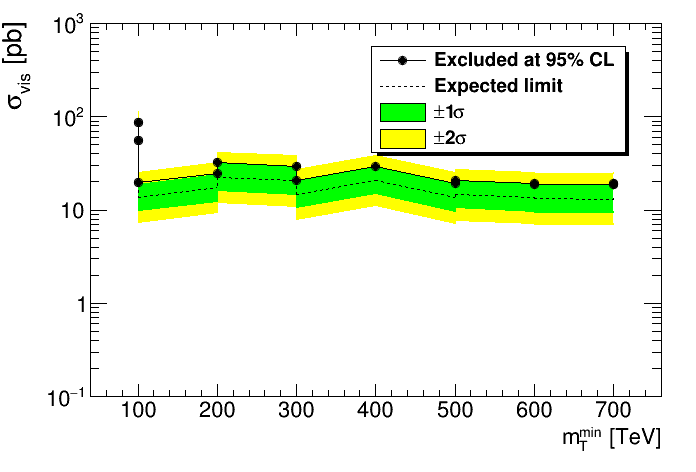

In [71]:
#%jsroot on
limPlot.drawPlot(xtitle = 'm_{T}^{min} [TeV]', ytitle = '#sigma_{vis} [pb]', yrange = [1e-1,1e3]);

### Making a standard limit plot - generalized example

As a slightly more advanced example, let's read in the inputs for all the mass points of the above mentioned 8 TeV W' search ([arXiv:1407.7494](https://arxiv.org/abs/1407.7494)), found in the file "inputs.txt". The idea is that you can replace the contents of this file with the inputs from your own analysis based on ATLAS Open Data.

In [35]:
import limitPlot;

limitPlots = {'combined': limitPlot.limitPlot('Combined')};

#peek in the input file to check which channels are there
inputFile = open('inputs.txt','r');
lines = inputFile.readlines();
for l in lines:

    exec(l); #Input file consists of valid Python statements such as mass=300 etc.

    if 'channel=' in l:
        if not channel in limitPlots.keys():
            limitPlots[channel] = limitPlot.limitPlot(channel);

print( 'Will make the following limit plots:' );
print(limitPlots);
            
countexp = {};
xtitle='Mass';
ytitle='Cross section';
yrange=[-999.0,-999.0];

#read the inputs and fill in the respective limit plots with background levels, observed counts, etc. 
f = open('inputs.txt');
for l in f.readlines():

    exec(l); #Input file consists of valid Python statements such as mass=300 etc. 

    if 'mass=' in l: #Such a line defines a new point in the limit plot
        for channel in limitPlots.keys():
            countexp[channel] = pyStats.countingExperiment(name = 'mass = '+str(mass), intLum = intLum, intLumUnc = intLumUncertainty);
            limitPlots[channel].addPoint(mass, countexp[channel], theoryCrossSection);

    if 'channel=' in l: #Such a line gives the inputs for a given channel     
        countexp['combined'].addChannel(name = channel, bkg = background, bkgUnc = backgroundUncertainty, Nobs = Nobs, eff = efficiency, effUnc = efficiencyUncertainty);
        countexp[channel].addChannel(name = channel, bkg = background, bkgUnc = backgroundUncertainty, Nobs = Nobs, eff = efficiency, effUnc = efficiencyUncertainty);


Will make the following limit plots:
{'combined': Limit plot "Combined", 'electron': Limit plot "electron", 'muon': Limit plot "muon"}


Now, let's inspect the setup we have for the electron channel limits, as an example:

In [36]:
print(limitPlots['electron']);

Limit plot "electron"

The plot consists of the following points:

x-axis value: 300
theory prediction: 149068.67611242065
---------------------------
Counting experiment "mass = 300"
---------------------------
Int. luminosity = 20.28 +/- 0.5678
---------------------------
Channel "electron":
   Background = 12901.4 +/- 816.767129814
   Observed events = 12717
   Signal efficiency = 0.22758 +/- 0.00930046154813
x-axis value: 400
theory prediction: 50251.76940500217
---------------------------
Counting experiment "mass = 400"
---------------------------
Int. luminosity = 20.28 +/- 0.5678
---------------------------
Channel "electron":
   Background = 5280.09 +/- 362.350827179
   Observed events = 5176
   Signal efficiency = 0.318907 +/- 0.0121244184741
x-axis value: 500
theory prediction: 21393.20332650292
---------------------------
Counting experiment "mass = 500"
---------------------------
Int. luminosity = 20.28 +/- 0.5678
---------------------------
Channel "electron":
   Backgro

At this point, we see that what's contained in the "limitPlot" object is just the inputs to the limit calculation. Let's run the actual calculation of the electron channel limits. By default, all the mass points will be run in parallel, and if there are enough CPUs available, the pseudo-experiments will additionally be split over several jobs.

In [37]:
limitPlots['electron'].calculate();

Again we can inspect the limit plot object, which now also contains the calculated limits:

In [38]:
print(limitPlots['electron']);

Limit plot "electron"

The plot consists of the following points:

x-axis value: 300
theory prediction: 149068.67611242065
---------------------------
Counting experiment "mass = 300"
---------------------------
Int. luminosity = 20.28 +/- 0.5678
---------------------------
Channel "electron":
   Background = 12901.4 +/- 816.767129814
   Observed events = 12717
   Signal efficiency = 0.22758 +/- 0.00930046154813
---------------------------
Limit setting results:
Observed limit: 340.81064703746955
Expected limit and bands:
  -2sigma                 -1sigma                 median                +1sigma                +2sigma
174.77469078844484    254.04749696749047    368.2752413042255    534.3111975532482    744.0408264993656    
x-axis value: 400
theory prediction: 50251.76940500217
---------------------------
Counting experiment "mass = 400"
---------------------------
Int. luminosity = 20.28 +/- 0.5678
---------------------------
Channel "electron":
   Background = 5280.09 +/- 362.35

And finally, we can produce the actual limit plot, which should be identical to Fig. 2 (top left) from the publication (you can uncomment the line "%jsroot on" if you want an interactive plot):

Info in <TCanvas::Print>: png file limitplot.png has been created


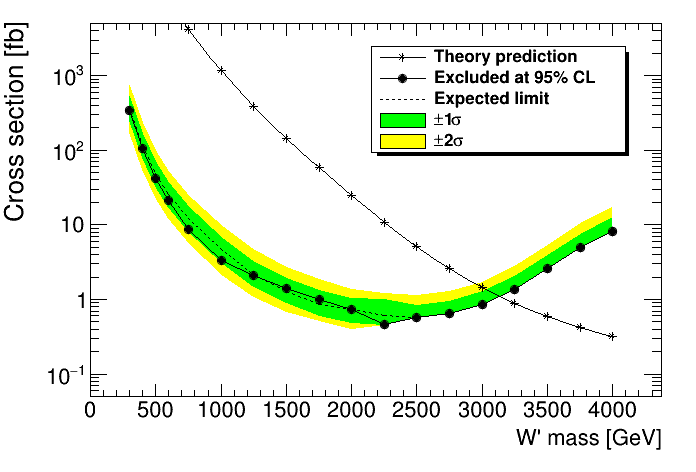

In [39]:
#%jsroot on
limitPlots['electron'].drawPlot(xtitle="W' mass [GeV]", ytitle="Cross section [fb]", yrange=[5.0e-2,5.0e3]);

The same can be done for the muon channel and combined limits. Note that the combined limit plot will not look identical to the published plot, because we here do not take into account the partial correlation of systematic uncertainties between the electron and muon channels.